In [1]:
import pandas as pd
import warnings
import rpy2
warnings.filterwarnings('ignore')

In [2]:
%load_ext rpy2.ipython

In [3]:
import plotly.graph_objects as go

def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Precio en dolares"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()

# 0 Importación de datos


In [4]:
import yfinance as yf

ticker_name = 'BC'

data = yf.download(ticker_name, start='2003-06-01', end='2013-06-01')
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(2518, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-06-02,22.080000,22.490000,22.049999,22.200001,16.651125,519800
2003-06-03,22.200001,22.480000,22.200001,22.400000,16.801130,327000
2003-06-04,22.370001,23.139999,22.370001,23.000000,17.251154,444100
2003-06-05,22.900000,23.240000,22.799999,23.150000,17.363665,394200
2003-06-06,25.010000,25.080000,24.100000,24.150000,18.113718,905600


In [5]:
df = pd.DataFrame()
df["Date"] = pd.to_datetime(data.index)
df["Close"] = data["Close"].values
display(df.head(10))
display(df.shape)

df_completo = df.copy()
df_completo.set_index('Date', inplace=True)
df_completo = df_completo.resample('1D').mean().ffill()
display(df_completo.head(10))
df_completo.shape

,Date,Close
0,2003-06-02,22.200001
1,2003-06-03,22.400000
2,2003-06-04,23.000000
3,2003-06-05,23.150000
4,2003-06-06,24.150000
5,2003-06-09,24.540001
6,2003-06-10,24.660000
7,2003-06-11,25.120001
8,2003-06-12,25.090000
9,2003-06-13,25.170000


(2518, 2)

,Close
Date,
2003-06-02,22.200001
2003-06-03,22.400000
2003-06-04,23.000000
2003-06-05,23.150000
2003-06-06,24.150000
2003-06-07,24.150000
2003-06-08,24.150000
2003-06-09,24.540001
2003-06-10,24.660000


(3652, 1)

In [6]:

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df_completo)
train_size = int(n * train_ratio)
val_size = int(n * val_ratio)

train_data = df_completo.iloc[:train_size]
val_data = df_completo.iloc[train_size:train_size+val_size]
test_data = df_completo.iloc[train_size+val_size:]

plot_("Train and Test Data",
      (train_data.index, train_data['Close'], "Train Data"),
      (test_data.index, test_data['Close'], "Test Data"),
      (val_data.index, val_data['Close'], "Validation Data"))

Este código implementa tres variantes del modelo ETS ("AAd", "AA", "AM") para predecir los precios de cierre de una serie temporal financiera. Los datos se segmentan en **70% para entrenamiento**, **15% para validación** y **15% para prueba**. Los hiperparámetros ajustados son **`alpha`** (suavización del nivel) y **`beta`** (suavización de la tendencia), los cuales se optimizan utilizando la función `gp_minimize` en un rango de **0.01 a 0.99**. Se busca minimizar el **error cuadrático medio (MSE)** en el conjunto de validación. La optimización bayesiana se ejecuta con 50 iteraciones por modelo para encontrar las combinaciones óptimas de estos parámetros.

Luego de obtener los mejores valores de `alpha` y `beta`, se realiza una predicción deslizante en los datos de prueba, ajustando continuamente el modelo a medida que se agregan más puntos de datos. Además, se lleva a cabo un análisis de residuos donde se evalúan la **autocorrelación** y la **tendencia** de los residuos, para asegurarse de que el modelo captura adecuadamente los patrones de la serie. Esto es crucial para detectar posibles comportamientos erráticos o no modelados correctamente.

In [7]:
import pandas as pd
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
import warnings
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
from skopt import gp_minimize
from skopt.space import Real

warnings.filterwarnings('ignore')

# Supongamos que `df_completo` ya está cargado y tiene las columnas 'Date' y 'Close'
# Segmentación de los datos
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
n = len(df_completo)
train_size = int(n * train_ratio)
val_size = int(n * val_ratio)

train_data = df_completo.iloc[:train_size]
val_data = df_completo.iloc[train_size:train_size + val_size]
test_data = df_completo.iloc[train_size + val_size:]

# Configuración de los modelos
models = ["AAd", "AA", "AM"]

# DataFrame para almacenar los mejores parámetros
best_params = pd.DataFrame(columns=["Modelo", "Parametro", "Valor"])

# Función para entrenar y predecir usando ETS sin estacionalidad
def train_and_predict(df, error, trend, damped, alpha, beta):
    model = ETSModel(df['Close'], error=error, trend=trend, damped_trend=damped)
    fitted_model = model.fit(disp=False, maxiter=1000, use_boxcox=True, smoothing_level=alpha, smoothing_slope=beta)
    return fitted_model.forecast(steps=1), fitted_model

def plot_residuals_and_stats(residuals, title, ax):
    # Residuos
    ax.plot(residuals)
    ax.set_title(f'Residuos - {title}')

    # Autocorrelación
    sm.graphics.plot_acf(residuals, ax=ax.figure.add_subplot(3, 1, 2))
    ax.figure.axes[1].set_title('Autocorrelación')

    # Tendencia
    trend = np.polyfit(np.arange(len(residuals)), residuals, 1)[0]
    r, p = pearsonr(np.arange(len(residuals)), residuals)
    ax.figure.add_subplot(3, 1, 3).plot(np.arange(len(residuals)), residuals, 'b-')
    ax.figure.add_subplot(3, 1, 3).plot(np.arange(len(residuals)), trend * np.arange(len(residuals)), 'r--')
    ax.figure.add_subplot(3, 1, 3).set_title(f'Tendencia (r={r:.2f}, p={p:.2f})')

    plt.tight_layout()

# Optimización de parámetros en el conjunto de validación
for model in tqdm(models, desc="Optimización de Parámetros"):
    # Mapear los valores de modelo a los valores correctos de 'trend' y 'damped'
    trend = 'add' if model[1] == 'A' else 'mul'
    damped = 'd' in model

    def objective(params):
        alpha, beta = params
        pred, fitted_model = train_and_predict(train_data, error='add', trend=trend, damped=damped, alpha=alpha, beta=beta)
        val_predictions = fitted_model.forecast(steps=len(val_data))
        mse = mean_squared_error(val_data['Close'], val_predictions)
        return mse

    bounds = [(0.01, 0.99), (0.01, 0.99)]
    res = gp_minimize(objective, bounds, n_calls=50, random_state=42)

    best_alpha, best_beta = res.x
    best_params = pd.concat([best_params, pd.DataFrame({
        "Modelo": [model],
        "Parametro": ["alpha"],
        "Valor": [best_alpha]
    })], ignore_index=True)

    best_params = pd.concat([best_params, pd.DataFrame({
        "Modelo": [model],
        "Parametro": ["beta"],
        "Valor": [best_beta]
    })], ignore_index=True)

display(best_params)

# Rolling prediction en los datos de prueba usando los mejores parámetros
test_residuals = {model: [] for model in models}

for i in tqdm(range(len(test_data)), desc="Rolling ETS models"):
    expanded_train_data = pd.concat([train_data, test_data.iloc[:i]])

    for model in models:
        trend = 'add' if model[1] == 'A' else 'mul'
        damped = 'd' in model

        pred, fitted_model = train_and_predict(expanded_train_data, 
                                               error='add', 
                                               trend=trend, 
                                               damped=damped,
                                               alpha=best_params[(best_params["Modelo"] == model) & (best_params["Parametro"] == "alpha")]["Valor"].values[0],
                                               beta=best_params[(best_params["Modelo"] == model) & (best_params["Parametro"] == "beta")]["Valor"].values[0])

        test_residuals[model].append(test_data['Close'].iloc[i] - pred.iloc[0])



Optimización de Parámetros: 100%|██████████| 3/3 [01:22<00:00, 27.59s/it]


,Modelo,Parametro,Valor
0,AAd,alpha,0.790612
1,AAd,beta,0.189766
2,AA,alpha,0.790612
3,AA,beta,0.189766
4,AM,alpha,0.790612
5,AM,beta,0.189766


Rolling ETS models: 100%|██████████| 549/549 [04:52<00:00,  1.87it/s]


Los hiperparámetros obtenidos para los modelos **AAd**, **AA** y **AM** muestran los mismos valores de **`alpha`**  = 0.7906 y **`beta`**  = 0.1897. Un **`alpha`** alto indica que el modelo da más peso a los valores recientes, lo que sugiere que la serie temporal tiene cambios rápidos y las observaciones recientes son cruciales para las predicciones. Por otro lado, un **`beta`** bajo indica que la tendencia cambia lentamente, lo que sugiere un patrón estable a largo plazo, sin variaciones bruscas en la tendencia.

In [10]:
plot_("Predicción ETS", (test_data.index, test_data['Close'], "Datos de Prueba"),
      (test_data.index, test_data['Close'] - test_residuals["AAd"], "Predicción AAd"),
      (test_data.index, test_data['Close'] - test_residuals["AA"], "Predicción AA"),
      (test_data.index, test_data['Close'] - test_residuals["AM"], "Predicción AM"))

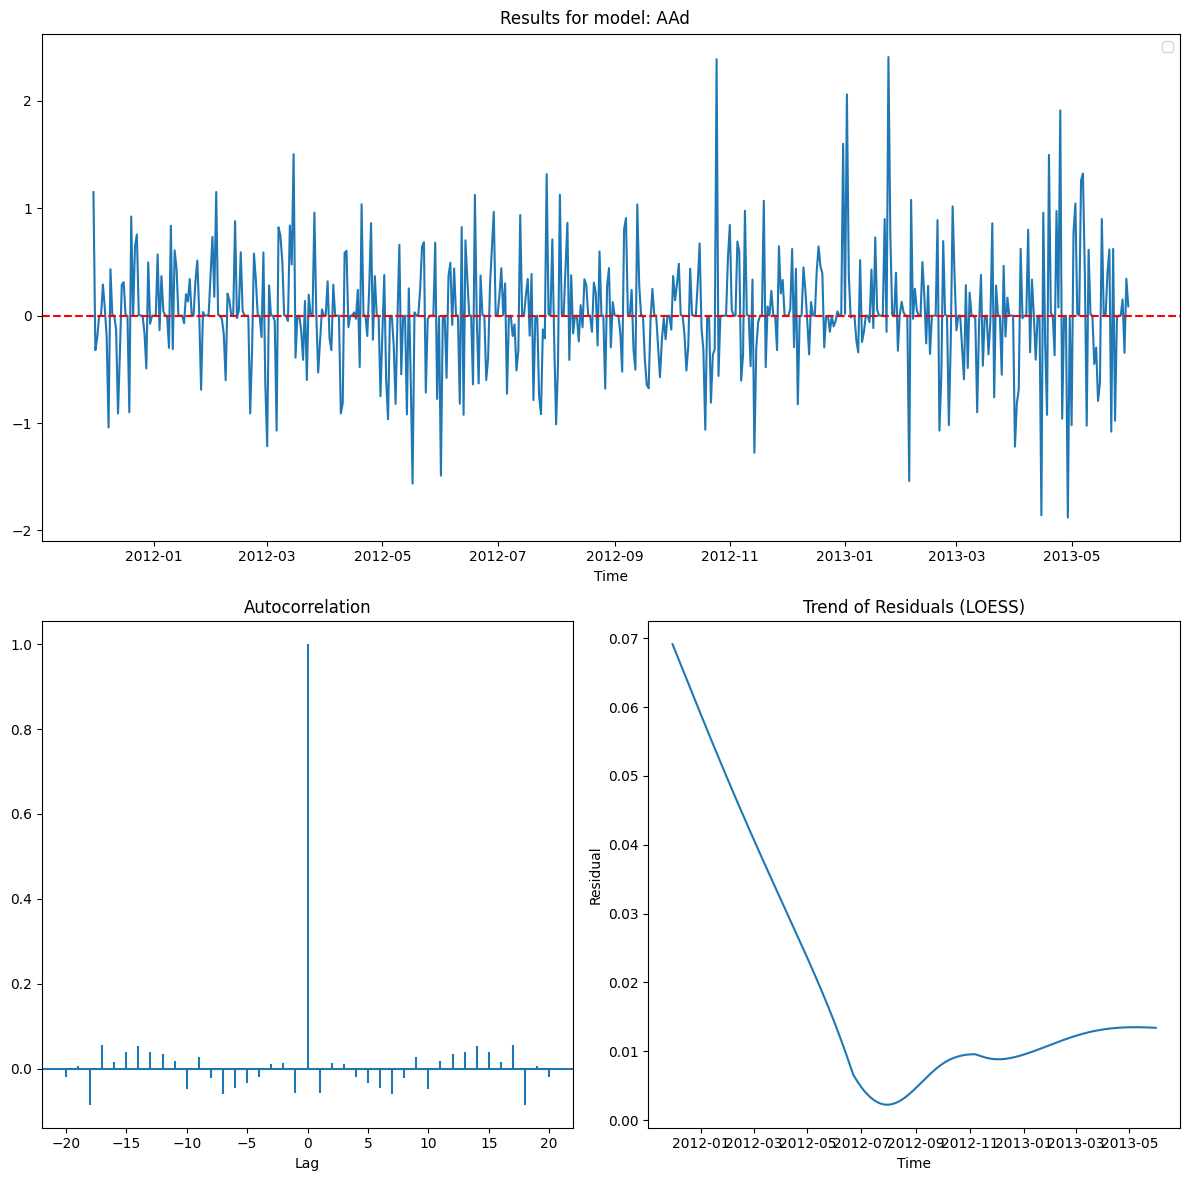

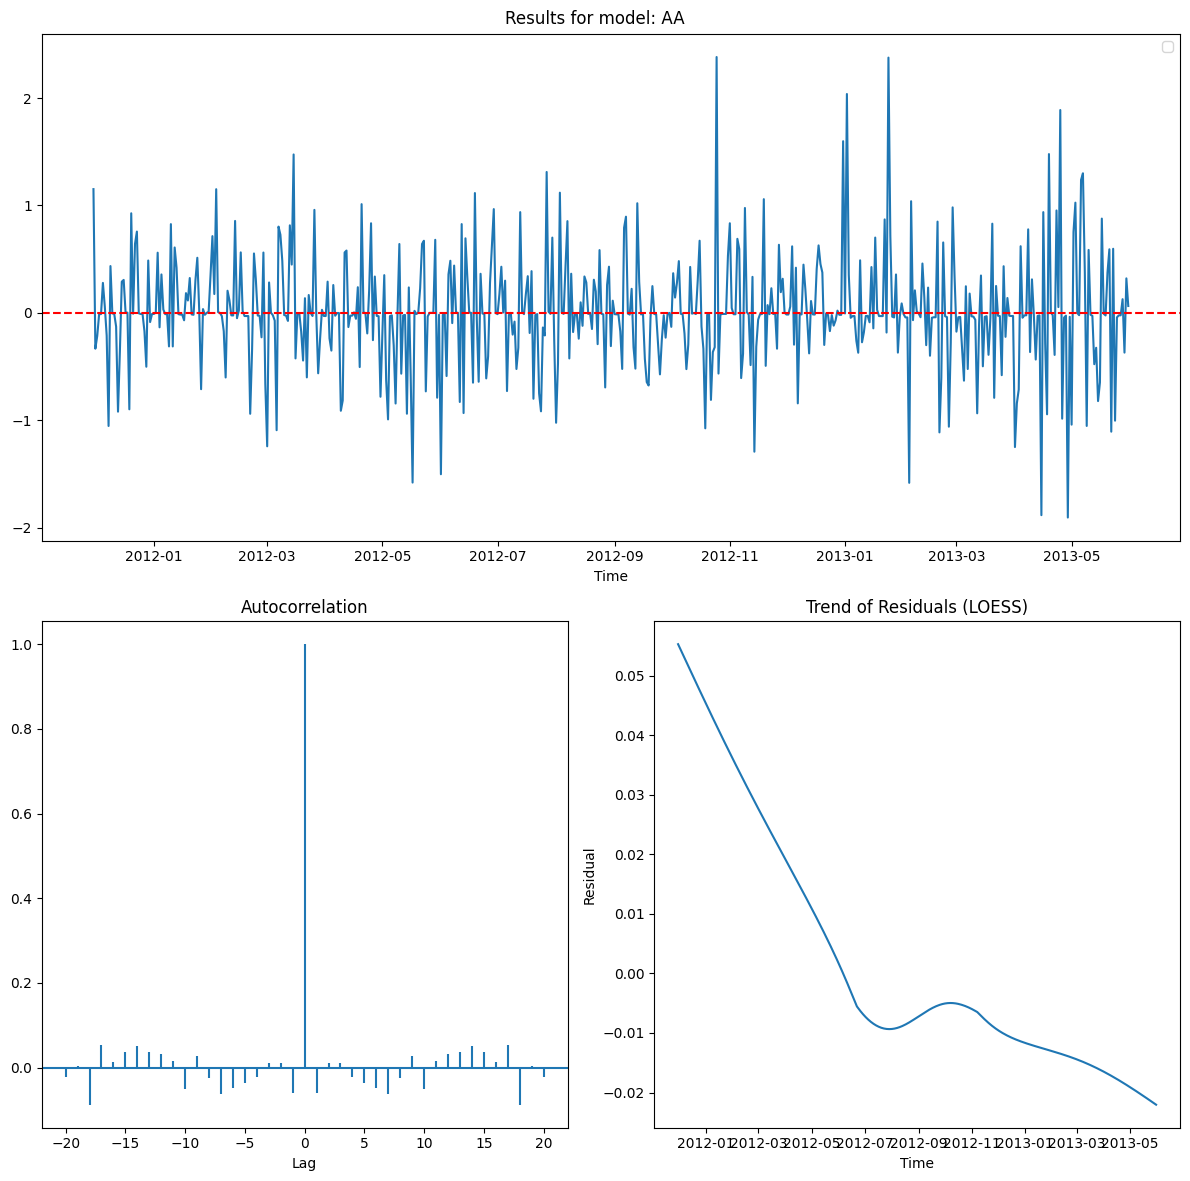

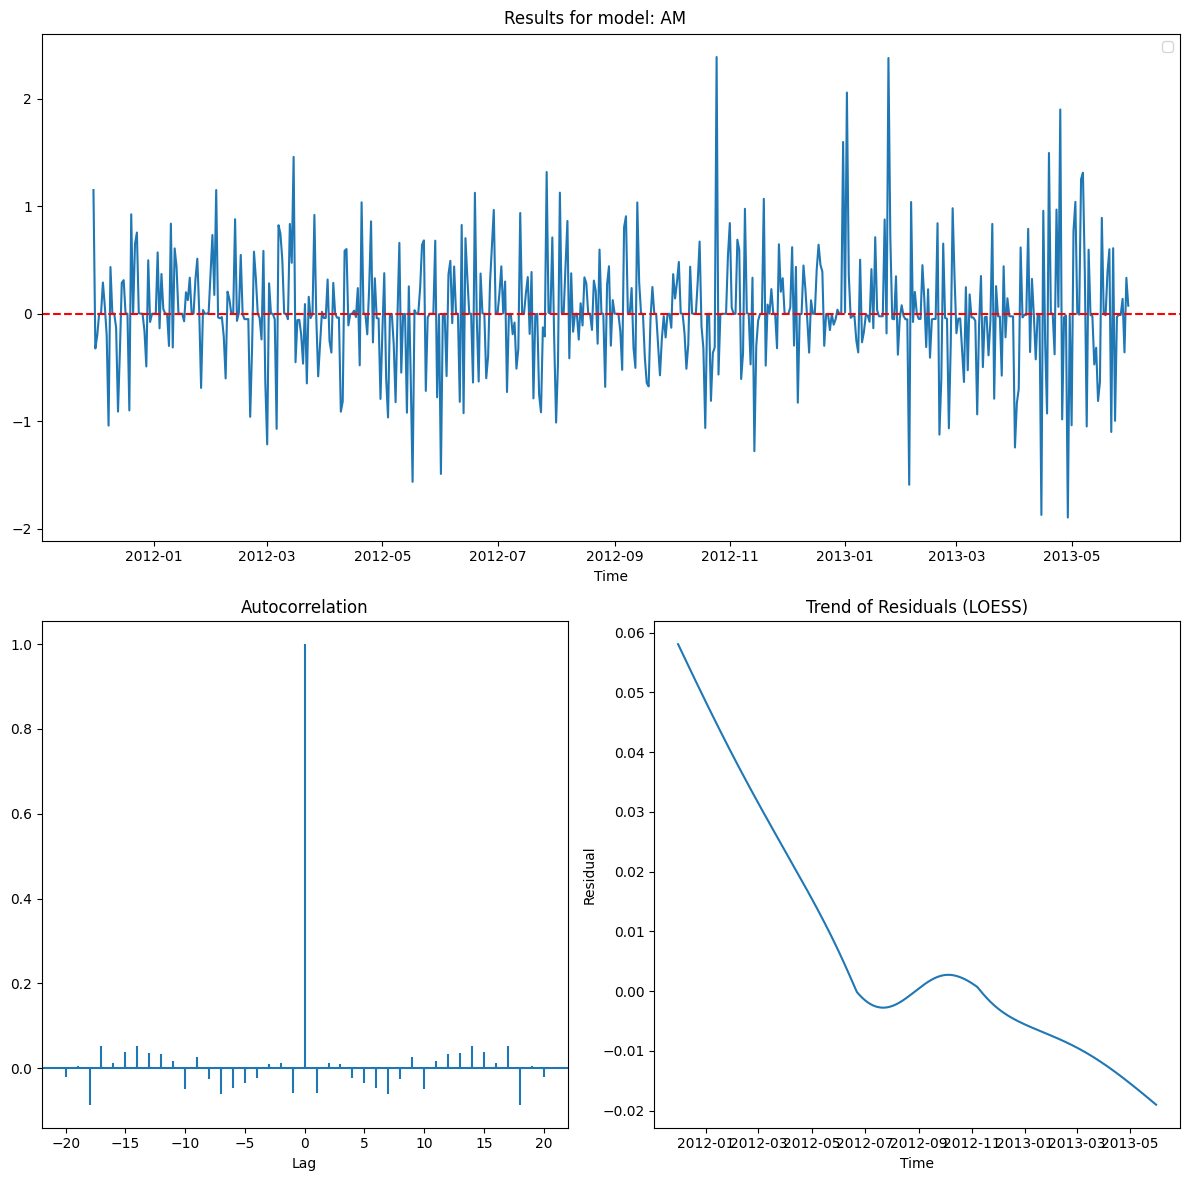

,Family,Model,MSE
0,ETS,AAd,0.273729
1,ETS,AA,0.274045
2,ETS,AM,0.274758


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

def plot_residuals_and_stats(date, test_residual, title, fig, axs):
    plt.suptitle(f'Results for model: {title}')
    
    # Residuals
    axs["A"].plot(date, test_residual)
    axs["A"].set_xlabel('Time')
    axs["A"].axhline(0, color='red', linestyle='--')
    axs["A"].legend()
    
    # Autocorrelation
    axs["B"].acorr(test_residual, maxlags=20)
    axs["B"].set_title('Autocorrelation')
    axs["B"].set_xlabel('Lag')
    
    # Trend of Residuals (LOESS)
    lowess = sm.nonparametric.lowess(test_residual, date, frac=0.75)
    axs["C"].plot(date, lowess[:, 1])
    axs["C"].set_title('Trend of Residuals (LOESS)')
    axs["C"].set_xlabel('Time')
    axs["C"].set_ylabel('Residual')
    
    plt.tight_layout()

for model in models:
    fig, axs = plt.subplot_mosaic("AA;BC", figsize=(12, 12))
    plot_residuals_and_stats(test_data.index, test_residuals[model], model, fig, axs)
    plt.show()

mse_results_ETS = {
    "Family": "ETS",
    "Model": models,
    "MSE": [mean_squared_error(test_data['Close'], test_data['Close'] - test_residuals[model]) for model in models]
}

mse_ETS = pd.DataFrame(mse_results_ETS).sort_values(by='MSE').reset_index(drop=True)
display(mse_ETS)

En los tres casos, se observa que los modelos no tienen sesgos, ni tendencias en los residuos considerables, ademas que explica la autocorrelación de las variables, lo que sugiere que los modelos capturan adecuadamente los patrones de la serie temporal. Por último, se observa que los modelos tienen un desempeño similar en el conjunto de prueba.